In [76]:
# declare imports
import argparse
from datetime import datetime
from pathlib import Path
import os
import sys
import dask.dataframe as dd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

path_to_functions = os.path.abspath("../src")

# Add this folder to the system path
sys.path.append(path_to_functions)

from pearl.post_processing.bmi import (
    add_summary,
    calc_overall_risk,
    calc_percentage,
    calc_percentage_and_add_summary,
    calc_risk_by_group,
    clean_control,
    create_summary_table,
    group_order,
    group_order_with_sub_total,
    group_title_dict,
    palette,
    rearrange_group_order,
    round_thousand,
    calc_dm_prop,
    add_sub_total
)

start_time = datetime.now()
df_summary_dict = {}

# Define the argument parser

baseline_dir = Path('../out/S0_10/combined')
variable_dir = Path('../out/S3_10/combined')
out_dir = Path('../results')

start_year = 2013
end_year = 2017

# Function

In [77]:
def calc_overall_bmi_risk(df: pd.DataFrame, years_follow_up: int = 7) -> pd.DataFrame:
    # filter for only overall group
    df_overall = df[df["group"] == "overall"]

    # filter for only follow_up-year follow up with dm
    df_overall_follow_up = df_overall.loc[
        (df_overall["years_after_h1yy"] > 0) & (df_overall["years_after_h1yy"] <= years_follow_up)
    ]

    # group by replication and age group and sum
    df_overall_follow_up_sum = (
        df_overall_follow_up.groupby(["init_bmi_group", "replication"])["n"].sum().reset_index()
    )
    df_overall_follow_up_sum = df_overall_follow_up_sum.rename(columns={"n": "dm_num"})

    # now for the denominator
    # First adjust people died in the same year of art initiation
    df_overall["time_exposure_to_risk"] = df_overall["time_exposure_to_risk"].where(
        df_overall["time_exposure_to_risk"] == 0, 1
    )

    # Second adjust people survive from simulation
    df_overall["time_exposure_to_risk"] = df_overall["time_exposure_to_risk"].where(
        df_overall["time_exposure_to_risk"] < 0, years_follow_up
    )

    # Third adjust people survived through follow-up period
    df_overall["time_exposure_to_risk"] = df_overall["time_exposure_to_risk"].where(
        df_overall["time_exposure_to_risk"] > years_follow_up, years_follow_up
    )

    # Calculate person-time variable
    df_overall["person-time-contributed"] = df_overall["n"] * df_overall["time_exposure_to_risk"]

    # group by replication and age group and sum
    df_overall_follow_up_sum_total = (
        df_overall.groupby(["init_bmi_group", "replication"])[["person-time-contributed", "n"]]
        .sum()
        .reset_index()
    )
    df_overall_follow_up_sum_total = df_overall_follow_up_sum_total.rename(columns={"n": "num"})

    # create risk table and calculate risk
    dm_risk_table = dd.merge(  # type: ignore [attr-defined]
        df_overall_follow_up_sum, df_overall_follow_up_sum_total, how="left"
    )
    dm_risk_table["risk"] = dm_risk_table["dm_num"] / dm_risk_table["person-time-contributed"]

    dm_risk_table["risk"] = dm_risk_table["risk"] * 1000

    return dm_risk_table

# Age Group

In [78]:
##################################################################################################################################
# we will look at the "bmi_int_dm_prev.h5" for S0
bmi_int_dm_prev = dd.read_parquet(baseline_dir / "dm_final_output.parquet").reset_index()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall["group"] = "overall"
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_age_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True)

# Figure 2A
dm_risk_table = calc_overall_risk(control_bmi_int_dm_prev).compute()

In [79]:
##################################################################################################################################
# we will look at the "bmi_int_dm_prev.h5" for S0
bmi_int_dm_prev = dd.read_parquet(variable_dir / "dm_final_output.parquet").reset_index()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall["group"] = "overall"
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_age_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True)

# Figure 2A
dm_risk_table_S1 = calc_overall_risk(control_bmi_int_dm_prev).compute()

In [80]:
S0_sample = (
        dm_risk_table.groupby("init_age_group")
        .apply(lambda x: x.sample(20, replace=True))
        .reset_index(drop=True)
    )

S1_sample = (
        dm_risk_table_S1.groupby("init_age_group")
        .apply(lambda x: x.sample(20, replace=True))
        .reset_index(drop=True)
    )

S0_sample = S0_sample.sort_values(by = 'init_age_group').reset_index(drop = True)
S1_sample = S1_sample.sort_values(by = 'init_age_group').reset_index(drop = True)

risk_df = S0_sample.copy()
risk_df['risk_S1'] =S1_sample['risk']

risk_df['abs_reduction'] = risk_df['risk'] - risk_df['risk_S1']
risk_df['rel_reduction'] = (risk_df['risk'] - risk_df['risk_S1'])/risk_df['risk'] * 100

C:\Users\jackz\AppData\Local\Temp\ipykernel_13192\2940801998.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(20, replace=True))
C:\Users\jackz\AppData\Local\Temp\ipykernel_13192\2940801998.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(20, replace=True))


In [81]:
risk_df = S0_sample.copy()
risk_df['risk_S1'] =S1_sample['risk']

risk_df['abs_reduction'] = risk_df['risk'] - risk_df['risk_S1']
risk_df['rel_reduction'] = (risk_df['risk'] - risk_df['risk_S1'])/risk_df['risk'] * 100

In [82]:
risk_df

,init_age_group,replication,dm_num,person-time-contributed,num,risk,risk_S1,abs_reduction,rel_reduction
0,0,5,785,115808,16544,6.778461,6.021441,0.757020,11.168022
1,0,4,739,115010,16430,6.425528,5.824369,0.601159,9.355796
2,0,3,763,115549,16507,6.603259,6.021441,0.581818,8.811078
3,0,0,795,114030,16290,6.971850,5.839777,1.132073,16.237765
4,0,9,788,118020,16860,6.676834,5.843731,0.833103,12.477519
...,...,...,...,...,...,...,...,...,...
135,6,1,13,917,131,14.176663,15.873016,-1.696353,-11.965812
136,6,8,16,945,135,16.931217,23.280423,-6.349206,-37.500000
137,6,5,17,882,126,19.274376,10.822511,8.451866,43.850267
138,6,2,16,770,110,20.779221,11.995638,8.783583,42.270992


## Abs

C:\Users\jackz\AppData\Local\Temp\ipykernel_13192\3686178435.py:1: UserWarning: The palette list has more values (16) than needed (7), which may not be intended.
  bar_ax = sns.boxplot(


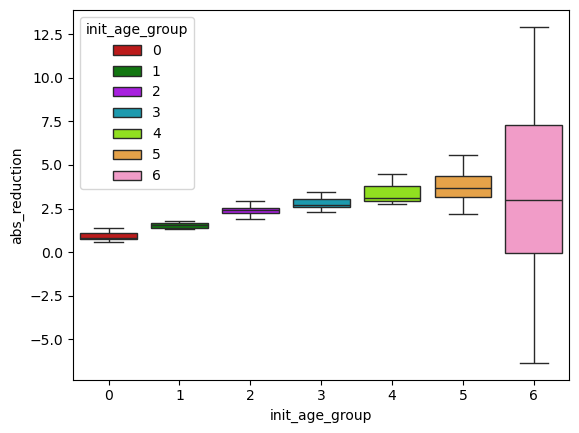

In [83]:
bar_ax = sns.boxplot(
        x=risk_df["init_age_group"],
        y=risk_df["abs_reduction"],
        palette=palette,
        hue=risk_df["init_age_group"],
    )

## Rel

C:\Users\jackz\AppData\Local\Temp\ipykernel_13192\2712843278.py:1: UserWarning: The palette list has more values (16) than needed (7), which may not be intended.
  bar_ax = sns.boxplot(


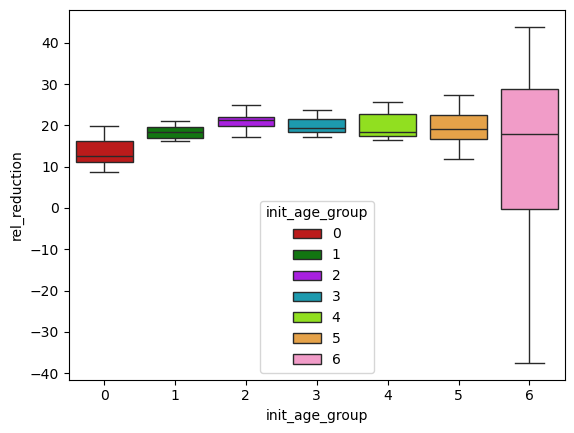

In [84]:
bar_ax = sns.boxplot(
        x=risk_df["init_age_group"],
        y=risk_df["rel_reduction"],
        palette=palette,
        hue=risk_df["init_age_group"],
    )

# BMI Group

In [85]:
##################################################################################################################################
# we will look at the "bmi_int_dm_prev.h5" for S0
bmi_int_dm_prev = dd.read_parquet(baseline_dir / "dm_final_output.parquet").reset_index()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall["group"] = "overall"
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_age_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True)

# Figure 2A
dm_risk_table = calc_overall_bmi_risk(control_bmi_int_dm_prev).compute()

In [86]:
##################################################################################################################################
# we will look at the "bmi_int_dm_prev.h5" for S0
bmi_int_dm_prev = dd.read_parquet(variable_dir / "dm_final_output.parquet").reset_index()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall["group"] = "overall"
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_age_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True)

# Figure 2A
dm_risk_table_S1 = calc_overall_bmi_risk(control_bmi_int_dm_prev).compute()

In [87]:
S0_sample = (
        dm_risk_table.groupby("init_bmi_group")
        .apply(lambda x: x.sample(20, replace=True))
        .reset_index(drop=True)
    )

S1_sample = (
        dm_risk_table_S1.groupby("init_bmi_group")
        .apply(lambda x: x.sample(20, replace=True))
        .reset_index(drop=True)
    )

S0_sample = S0_sample.sort_values(by = 'init_bmi_group').reset_index(drop = True)
S1_sample = S1_sample.sort_values(by = 'init_bmi_group').reset_index(drop = True)

risk_df = S0_sample.copy()
risk_df['risk_S1'] =S1_sample['risk']

risk_df['abs_reduction'] = risk_df['risk'] - risk_df['risk_S1']
risk_df['rel_reduction'] = (risk_df['risk'] - risk_df['risk_S1'])/risk_df['risk'] * 100

C:\Users\jackz\AppData\Local\Temp\ipykernel_13192\515529097.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(20, replace=True))
C:\Users\jackz\AppData\Local\Temp\ipykernel_13192\515529097.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(20, replace=True))


## Abs

In [88]:
bmi_group_map = {1:'[18.5-21.6]', 2:'[21.7-24.9]',3:'[25-27.4]',4:'[27.5-29.9]'}
group_order = ['[18.5-21.6]','[21.7-24.9]','[25-27.4]','[27.5-29.9]']
risk_df["init_bmi_group"] = risk_df["init_bmi_group"].map(bmi_group_map)

C:\Users\jackz\AppData\Local\Temp\ipykernel_13192\84540626.py:1: UserWarning: The palette list has more values (16) than needed (4), which may not be intended.
  bar_ax = sns.boxplot(


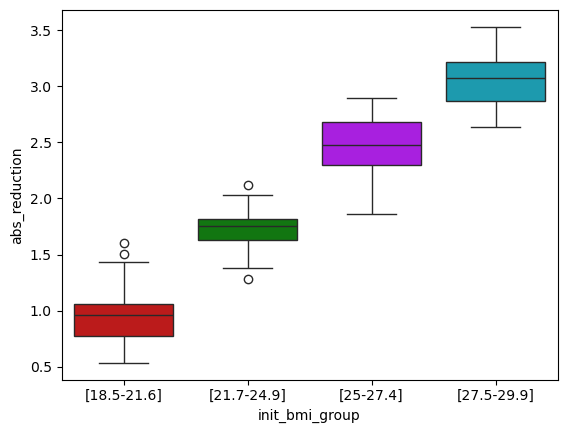

In [89]:
bar_ax = sns.boxplot(
        x=risk_df["init_bmi_group"],
        y=risk_df["abs_reduction"],
        palette=palette,
        hue=risk_df["init_bmi_group"],
        order = group_order,
    )

## Rel

C:\Users\jackz\AppData\Local\Temp\ipykernel_13192\2427357485.py:1: UserWarning: The palette list has more values (16) than needed (4), which may not be intended.
  bar_ax = sns.boxplot(


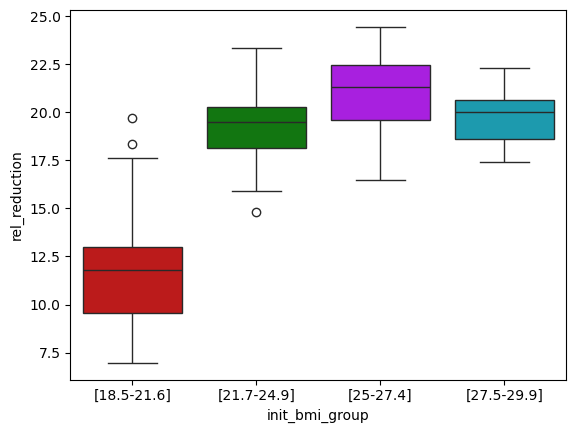

In [90]:
bar_ax = sns.boxplot(
        x=risk_df["init_bmi_group"],
        y=risk_df["rel_reduction"],
        palette=palette,
        hue=risk_df["init_bmi_group"],
        order = group_order,
    )